In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
%matplotlib inline

In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
N = 500
d = tfd.Uniform(low=0, high=2)
zs = d.sample(N)

Text(0.5, 0, 'z')

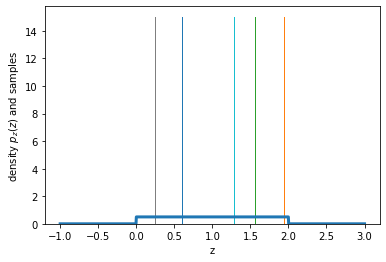

In [4]:
plt.hist(zs, density=True, bins=30)
zd = np.linspace(-1,3,1000)
plt.plot(zd, d.prob(zd), linewidth=3)
plt.ylabel('density $p_z(z)$ and samples')
plt.xlabel('z')

Text(0.5, 0, 'x')

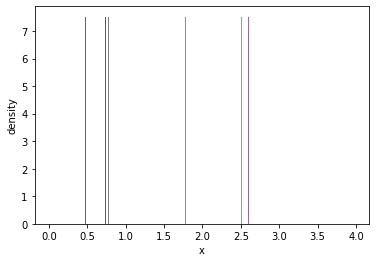

In [5]:
x = zs**2
plt.hist(x, density=True, bins=30)
plt.ylabel('density')
plt.xlabel('x')

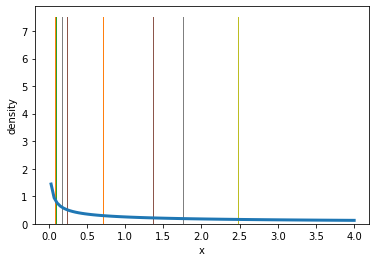

In [6]:
x = zs**2
plt.hist(x, density=True, bins=30)
plt.ylabel('density')
plt.xlabel('x')

xs = np.linspace(0.03,4,100)
plt.plot(xs, 1./2 * 1./2 * 1/np.sqrt(xs), linewidth=3)
plt.savefig('ch06_x2.pdf')
plt.show()

In [7]:
g = tfb.Square() # This is a bijector

In [8]:
g.forward(2.0) #4

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [9]:
g.inverse(4.0) #2

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [10]:
base_dist = tfd.Uniform(0.0,2.0)
mydist = tfd.TransformedDistribution(
    distribution=base_dist, bijector=g) # My dist is a new distribution

In [11]:
mydist.prob(3), mydist.sample(3)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.14433756>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.01505037, 3.2150474 , 2.9480858 ], dtype=float32)>)

(0.0, 1.0)

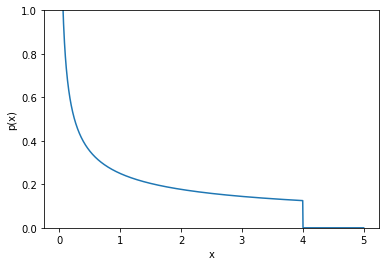

In [12]:
g = tfb.Square() #A 
db = tfd.Uniform(0.0,2.0) #A2
mydist = tfd.TransformedDistribution( #B
    distribution=db, bijector=g)

xs = np.linspace(0.001, 5,1000)
px = mydist.prob(xs) #C

#A The bijector, here a square function
#A2 The base distribution, here a uniform distribution
#B Combining a base distribution and a bijector to a new distribution 
#C The TransformedDistribution behaves like a usual Distribution

plt.plot(xs,px)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.ylim(0,1)

## Using chain

In [13]:
chain = tfb.Chain([tfb.Square(), tfb.Square()], name="x4")
chain.forward(2.0)

<tf.Tensor: shape=(), dtype=float32, numpy=16.0>

## Training Bijector

(1000, 1)

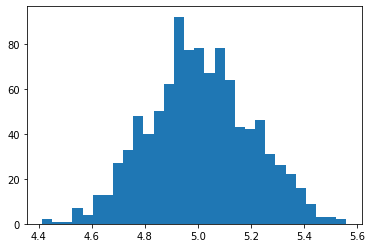

In [36]:
N = 1000
X = tfd.Normal(loc=5,scale=0.2).sample(1000)
X = X.numpy().reshape([N,1])
plt.hist(X,30)
X.shape

### Training in eager mode

What shall be the result? 

$z \sim N(0,1) \overbrace{\longrightarrow}^{g(z) = a\cdot z + b} x \sim N(5,0.2)$. 

Hence, $b = 5$ and $a = 0.2$

In [113]:
# Making a distribution using the flow and a N(0,1)
b = tf.Variable(0.0)
a = tf.Variable(1.0)

Be aware that chain is different from sequential use of bijector

In [114]:
chain = tfb.Chain([tfb.Shift(b), tfb.Scale(a)])
chain.forward(2.0)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [115]:
dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0,scale=1), bijector=chain)
dist.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>)

In [116]:
-tf.reduce_mean(dist.log_prob(X)) #The NLL of the whole training set

<tf.Tensor: shape=(), dtype=float32, numpy=13.473721>

In [117]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1) #quite high lr for normalizing flows.

In [118]:
for i in range(1000):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X)) #<-- The negative log-likelihood we want to minize 
        gradients = tape.gradient(loss,          #D 
                    dist.trainable_variables)     
    optimizer.apply_gradients(
        zip(gradients, dist.trainable_variables)) #E     
    
    if (i % 100 == 0):
        print(i, "NLL ",loss.numpy(), " Scale (a) ", a.numpy(), " Shift (b) ", b.numpy())

0 NLL  13.473721  Scale (a)  1.1  Shift (b)  0.099999934
100 NLL  1.9138358  Scale (a)  2.4554722  Shift (b)  3.981906
200 NLL  0.28962526  Scale (a)  0.4429593  Shift (b)  5.009359
300 NLL  -0.21576  Scale (a)  0.19421986  Shift (b)  5.0071745
400 NLL  -0.21576849  Scale (a)  0.19501051  Shift (b)  5.0071483
500 NLL  -0.21576858  Scale (a)  0.19500959  Shift (b)  5.0071483
600 NLL  -0.21576853  Scale (a)  0.19500957  Shift (b)  5.0071483
700 NLL  -0.21576846  Scale (a)  0.19500959  Shift (b)  5.0071483
800 NLL  -0.21576852  Scale (a)  0.19500957  Shift (b)  5.0071487
900 NLL  -0.21576847  Scale (a)  0.1950096  Shift (b)  5.007148


Text(0.5, 0, 'x')

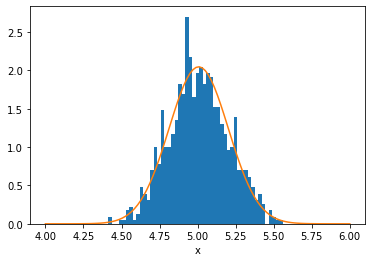

In [119]:
xx = np.linspace(4,6,100)
plt.hist(X, bins=50,density=True)
plt.plot(xx, dist.prob(xx) )
plt.xlabel('x')

In [120]:
dist.mean()

<tf.Tensor: shape=(), dtype=float32, numpy=5.0071487>

In [121]:
dist.stddev()

<tf.Tensor: shape=(), dtype=float32, numpy=0.19500971>

In [122]:
dist.prob(5.0)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0443833>

In [123]:
dist.quantile(0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0071487>